# Stim. rep. (time-constrained)

author: steeve.laquitaine@epfl.ch  
date: 21.02.1984

**purpose**: describe time-constrained population response patterns.

## Method
### Task

* task parameters (see bbp_workflow config):
    * start delay: 1000 ms
    * stimulus delay: 1500 ms
    * 360 stimuli x 50 repeated trials for characterizing the tuning curves
    * interstimulus interval: 200 ms

### Dataset 

* data:
    1. 36 simulation files
    2. bbp_workflow config script spikesorting_stim_rotations.py indicates 36 files with orientations for file 1: 0 to 9, file 2: 10 to 19 etc...
    3. png files confirm point 2): /gpfs/bbp.cscs.ch/project/proj83/scratch/home/isbister/post_physiology_2023/sim_data/campaigns/spikesorting_stimulus_tests/4_spikesorting_stimulus_test_neuropixels_8-1-24/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/35
    5. Thus: Each simulation file is organized as: simulation file duration (101500 ms) = start delay of 1500 ms then 10 repeats of (orientation for 9800 ms followed by 200 ms of ISI

### Cebra

* Cebra-time: self-supervised

### Setup

1. activate spikeinterf..

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import spikeinterface as si
import numpy as np
from collections import Counter
import pandas as pd
import warnings
import pickle
from sklearn.preprocessing import LabelEncoder
import yaml

# dimensionality reduction
from cebra import CEBRA
import cebra

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# GET STIMULUS CONF
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config

data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["probe_wiring"]["output"]


# GET STIM-REP CONF
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/stim-rep"
os.chdir(PROJ_PATH)

with open(
    f"conf/silico_npx/stimulus/dataset.yml",
    "r",
    encoding="utf-8",
) as data_conf:
    data_conf = yaml.safe_load(data_conf)

# MODELS
CEBRA_MODEL_MTLYR_TRIAL_PATH = data_conf['models']['cebra']['models']['multilayer_trialwise']

# EMBEDDINGS
CEBRA_EMBED_MTLYR_TRIAL_PATH = data_conf['models']['cebra']['embed']['multilayer_trialwise']

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files

# FIGURE SETTINGS
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi":300} 

2024-05-10 15:22:48,486 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-10 15:22:48,513 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [2]:
def get_stimulus_intervals_ms(epoch_labels, epoch_ms):

    # find stimulus epoch starts and ends
    epoch_end_ms = np.cumsum(epoch_ms)
    epoch_start_ms = np.hstack([0, epoch_end_ms])[:-1]
    df = pd.DataFrame(data=epoch_end_ms)
    df.columns = ["end"]
    df.insert(0, "start", epoch_start_ms)
    df.index = epoch_labels

    # get stimulus intervals
    return [tuple(df.iloc[ix]) for ix in range(len(df)) if df.index[ix] == "stimulus"]


def get_stimulus_labels():
    start = np.arange(0, 360, 10)
    end = np.arange(10, 370, 10)

    stimulus_labels = []
    for ix in range(36):
        stimulus_labels.append(np.repeat(np.arange(start[ix], end[ix], 1), 50))
    return np.array(stimulus_labels).flatten()


def get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
):
    # get epoch timings
    epoch_ms = n_simulations * (
        [start_delay] + n_orientations * n_repeats * [stimulus_duration]
    )
    # get epoch labels
    epoch_labels = n_simulations * (
        ["delay"] + n_orientations * n_repeats * ["stimulus"]
    )

    return {"epoch_labels": epoch_labels, "epoch_ms": epoch_ms}


def get_evoked_responses(spike_trains_ms: np.array, stim_intervals_ms: np.array):
    """_summary_

    Args:
        spike_trains_ms (np.array): _description_
        stim_intervals_ms (np.array): array of tuples (start, end)

    Returns:
        _type_: _description_
    """
    # Use numpy's digitize function to find the bin indices for each value
    bins = [interval[1] for interval in stim_intervals_ms]

    # Return the indices of the bins to which each value in spike_trains_ms belongs.
    bin_indices = np.digitize(spike_trains_ms, bins=bins)

    # Use Counter to count occurrences of bin indices
    interval_counter = Counter(bin_indices)

    # find active stimulus epochs
    active_bin_spike_count = [items[1] for items in list(interval_counter.items())]
    active_bin_ix = [items[0] for items in list(interval_counter.items())]

    # cast unit responses by stimulus epoch in an array
    unit_responses = np.zeros(len(bins))
    unit_responses[active_bin_ix] = active_bin_spike_count
    return unit_responses


def convert_spike_trains_to_ms(spike_trains: np.array, sfreq: int):
    """_summary_

    Args:
        spike_trains (np.array): _description_
        sfreq (int): _description_

    Returns:
        _type_: _description_
    """
    sample_ms = 1 / (sfreq / 1000)
    spike_trains_ms = spike_trains * sample_ms
    return spike_trains_ms


def compute_response_by_stim_matrix(unit_ids, SortingTrueKS3, stimulus_intervals_ms):
    """_summary_

    Args:
        SortingTrueKS3 (_type_): _description_
        stimulus_intervals_ms (_type_): _description_

    Returns:
        _type_: _description_
    """
    SFREQ = SortingTrueKS3.get_sampling_frequency()

    # takes 18 secs
    responses = []
    for unit_id in unit_ids:
        spike_trains = SortingTrueKS3.get_unit_spike_train(unit_id)
        spike_trains_ms = convert_spike_trains_to_ms(spike_trains, SFREQ)
        responses.append(get_evoked_responses(spike_trains_ms, stimulus_intervals_ms))
    return np.array(responses)

### (22s) Load dataset

In [3]:
# sorting
SortingTrue = si.load_extractor(GT_SORTING_PATH)

# unit layers
unit_layers = SortingTrue.get_property("layer")
print("# of unit layers:", len(np.unique(unit_layers)))
print("unique unit layers:", np.unique(unit_layers))

# recording
Recording = si.load_extractor(RECORDING_PATH)
print("# of units:", len(SortingTrue.unit_ids))

# get task epoch infos
task = get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
)

# STIMULUS  ***********

# get stimulus labels
stimulus_labels = get_stimulus_labels()
print("# of stimulus trials:", len(stimulus_labels))
print("# of stimulus orientations:", len(np.unique(stimulus_labels)))

# get stimulus orientation labels
stimulus_intervals_ms = get_stimulus_intervals_ms(
    task["epoch_labels"], task["epoch_ms"]
)

print("orientations:", stimulus_intervals_ms)

# NEURAL RESPONSE ***********

# compute unit x stimulus response matrix
responses = compute_response_by_stim_matrix(
    SortingTrue.unit_ids, SortingTrue, stimulus_intervals_ms
)

# UNIT LABELS ***********

syn = SortingTrue.get_property("synapse_class")
enc = LabelEncoder()
unit_labels = [
    np.array([enc.fit_transform(syn[(unit_layers == "2") | (unit_layers == "3")])])
    .astype(np.float32)
    .T,
    np.array([enc.fit_transform(syn[unit_layers == "4"])]).astype(np.float32).T,
    np.array([enc.fit_transform(syn[unit_layers == "5"])]).astype(np.float32).T,
    np.array([enc.fit_transform(syn[unit_layers == "6"])]).astype(np.float32).T,
]

# of unit layers: 6
unique unit layers: ['1' '2' '3' '4' '5' '6']
# of units: 1836
# of stimulus trials: 18000
# of stimulus orientations: 360
orientations: [(500, 700), (700, 900), (900, 1100), (1100, 1300), (1300, 1500), (1500, 1700), (1700, 1900), (1900, 2100), (2100, 2300), (2300, 2500), (2500, 2700), (2700, 2900), (2900, 3100), (3100, 3300), (3300, 3500), (3500, 3700), (3700, 3900), (3900, 4100), (4100, 4300), (4300, 4500), (4500, 4700), (4700, 4900), (4900, 5100), (5100, 5300), (5300, 5500), (5500, 5700), (5700, 5900), (5900, 6100), (6100, 6300), (6300, 6500), (6500, 6700), (6700, 6900), (6900, 7100), (7100, 7300), (7300, 7500), (7500, 7700), (7700, 7900), (7900, 8100), (8100, 8300), (8300, 8500), (8500, 8700), (8700, 8900), (8900, 9100), (9100, 9300), (9300, 9500), (9500, 9700), (9700, 9900), (9900, 10100), (10100, 10300), (10300, 10500), (10500, 10700), (10700, 10900), (10900, 11100), (11100, 11300), (11300, 11500), (11500, 11700), (11700, 11900), (11900, 12100), (12100, 12300)

* For a fully unsupervised mode (not conditioned on time nor auxiliary variable), we selected the `time-offset=10` (distance in time between sampled positive pairs) and thus the architecture `offset10-model` (1 receptive field) as the docs recommend to use a time-offset large than the receptive field (1).
* We used the default model initialization (see 1).

### (40s) Plot neural embedding

['offset10-model', 'offset10-model-mse', 'offset5-model', 'offset1-model-mse', 'offset1-model', 'offset1-model-v2', 'offset1-model-v3', 'offset1-model-v4', 'offset1-model-v5', 'offset40-model-4x-subsample', 'offset20-model-4x-subsample', 'offset4-model-2x-subsample', 'offset36-model', 'offset36-model-dropout', 'offset36-model-more-dropout']


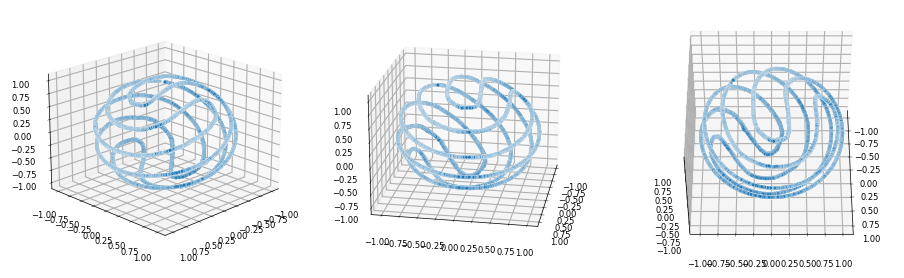

In [4]:
np.random.seed(0)

# PARAMETRIZE ********************************************************
print(cebra.models.get_options("offset*"))

MAX_ITER = 8000

# initialize model
cebra_model = CEBRA(
    model_architecture="offset10-model",  # 1 receptive field
    batch_size=1024,
    temperature_mode="auto",
    learning_rate=0.001,
    max_iterations=MAX_ITER,
    time_offsets=10,  # 1 timestep
    output_dimension=3,  # 3 dimensions
    device="cuda_if_available",
    verbose=False,
)

# TRAIN ********************************************************

# responses becomes trial x neurons
cebra_model.fit(responses.T)

# EMBED ********************************************************

embed = cebra_model.transform(responses.T)


# PLOT ********************************************************
SIZE = 6

# init plot
fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    embed[:, 0],
    embed[:, 1],
    embed[:, 2],
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.view_init(20, 10, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    embed[:, 0],
    embed[:, 1],
    embed[:, 2],
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.view_init(50, 0, 0)
scat = ax.scatter(
    embed[:, 0],
    embed[:, 1],
    embed[:, 2],
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

#### Map stimulus trials

<Figure size 200x100 with 0 Axes>

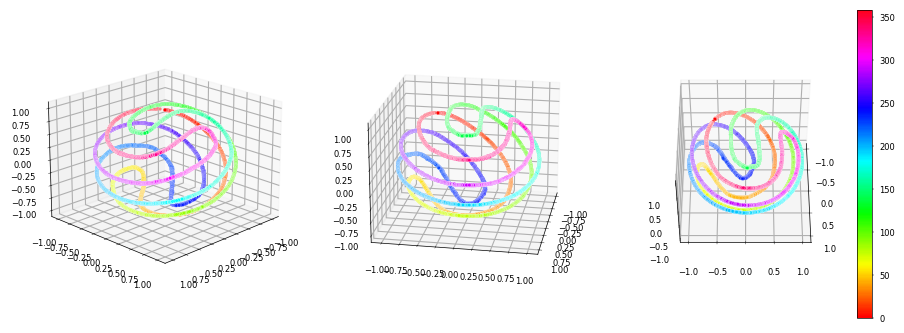

In [6]:
# PLOT ********************************************************
SIZE = 6

plt.set_cmap("hsv")  # circular cmap

# init plot
fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    embed[:, 0],
    embed[:, 1],
    embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.view_init(20, 10, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    embed[:, 0],
    embed[:, 1],
    embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.view_init(50, 0, 0)
scat = ax.scatter(
    embed[:, 0],
    embed[:, 1],
    embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)
plt.colorbar(scat)

#### Per layer

* train responses by layer separately
* align the embeddings and plot

<Figure size 200x100 with 0 Axes>

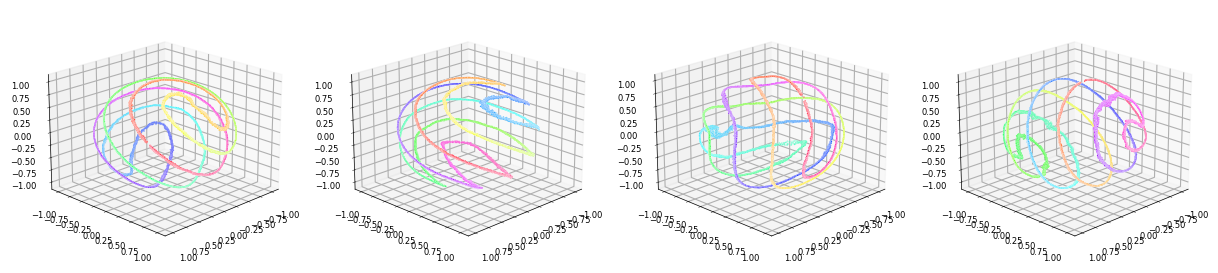

In [12]:
np.random.seed(0)

MAX_ITER = 8000
SIZE = 1

data_l23_exc = responses[(unit_layers == "2") | (unit_layers == "3"), :]
data_l4_exc = responses[(unit_layers == "4"), :]
data_l5_exc = responses[(unit_layers == "5"), :]
data_l6_exc = responses[(unit_layers == "6"), :]

model_cfg = {
    "model_architecture": "offset10-model",  # 1 receptive field
    "batch_size": 1024,
    "temperature_mode": "auto",
    "learning_rate": 0.001,
    "max_iterations": MAX_ITER,
    "time_offsets": 10,  # 1 timestep
    "output_dimension": 3,  # 3 dimensions
    "device": "cuda_if_available",
    "verbose": False,
}

# cebra - behavior model
cebra_l23_model = CEBRA(**model_cfg)
cebra_l4_model = CEBRA(**model_cfg)
cebra_l5_model = CEBRA(**model_cfg)
cebra_l6_model = CEBRA(**model_cfg)

# (3m) train and save ******************************************
# train

cebra_l23_model.fit(data_l23_exc.T)
cebra_l4_model.fit(data_l4_exc.T)
cebra_l5_model.fit(data_l5_exc.T)
cebra_l6_model.fit(data_l6_exc.T)

# get each layer's embedding
cebra_l23_embed = dict()
cebra_l4_embed = dict()
cebra_l5_embed = dict()
cebra_l6_embed = dict()

cebra_l23_embed = cebra_l23_model.transform(data_l23_exc.T)
cebra_l4_embed = cebra_l4_model.transform(data_l4_exc.T)
cebra_l5_embed = cebra_l5_model.transform(data_l5_exc.T)
cebra_l6_embed = cebra_l6_model.transform(data_l6_exc.T)

# Alignment ***********************************************

# Align the single session embeddings to L2/3
alignment = cebra.data.helper.OrthogonalProcrustesAlignment()

cebra_l4_embed = alignment.fit_transform(
    cebra_l23_embed, cebra_l4_embed, stimulus_labels, stimulus_labels
)
cebra_l5_embed = alignment.fit_transform(
    cebra_l23_embed, cebra_l5_embed, stimulus_labels, stimulus_labels
)
cebra_l6_embed = alignment.fit_transform(
    cebra_l6_embed, cebra_l6_embed, stimulus_labels, stimulus_labels
)

# plot ***********************************************

# init plot
plt.set_cmap("hsv")  # circular cmap
fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l23_embed[:, 0],
    cebra_l23_embed[:, 1],
    cebra_l23_embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l4_embed[:, 0],
    cebra_l4_embed[:, 1],
    cebra_l4_embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot ******************************************
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l5_embed[:, 0],
    cebra_l5_embed[:, 1],
    cebra_l5_embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l6_embed[:, 0],
    cebra_l6_embed[:, 1],
    cebra_l6_embed[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,
)

In [ ]:
names = ["L23", "L4", "L5", "L6"]

scores, pairs, layers = cebra.sklearn.metrics.consistency_score(
    embeddings=list([cebra_l23_embed, cebra_l4_embed, cebra_l5_embed, cebra_l6_embed]),
    labels=stimulus_labels,
    dataset_ids=names,
    between="datasets",
)

# Display consistency maps
fig = plt.figure(figsize=(11, 4))
ax1 = plt.subplot(111)
ax1 = cebra.plot_consistency(
    scores,
    pairs=pairs,
    datasets=layers,
    ax=ax1,
    title="layers",
    colorbar_label=None,
)

### (40s) Plot cells-trial as points ()

trial-latents

In [10]:
### reshape responses
cell_ids = SortingTrue.unit_ids

responses

stimulus_labels

array([  0,   0,   0, ..., 359, 359, 359])

In [ ]:
responses

In [ ]:
responses

['offset10-model', 'offset10-model-mse', 'offset5-model', 'offset1-model-mse', 'offset1-model', 'offset1-model-v2', 'offset1-model-v3', 'offset1-model-v4', 'offset1-model-v5', 'offset40-model-4x-subsample', 'offset20-model-4x-subsample', 'offset4-model-2x-subsample', 'offset36-model', 'offset36-model-dropout', 'offset36-model-more-dropout']


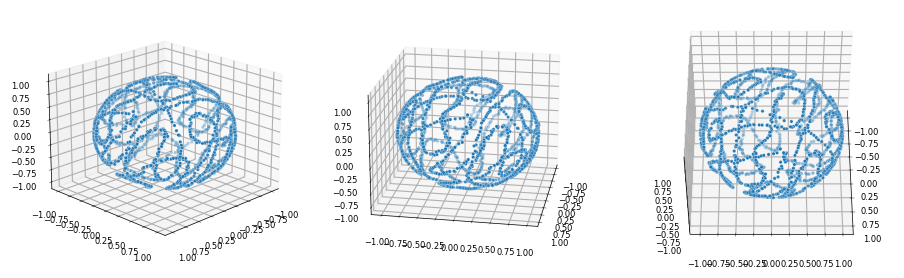

In [32]:
np.random.seed(0)

# PARAMETRIZE ********************************************************
print(cebra.models.get_options("offset*"))

MAX_ITER = 8000

# initialize model
cebra_model = CEBRA(
    model_architecture="offset1-model",  # 1 receptive field
    batch_size=1024,
    temperature_mode="auto",
    learning_rate=0.001,
    max_iterations=MAX_ITER,
    time_offsets=1,  # 1 timestep
    output_dimension=3,  # 3 dimensions
    device="cuda_if_available",
    verbose=False,
)

# TRAIN ********************************************************

# responses becomes neurons x trials
# get time latents
cebra_model.fit(responses)

# EMBED ********************************************************

embed = cebra_model.transform(responses)


# PLOT ********************************************************
SIZE = 6

# init plot
fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    embed[:, 0],
    embed[:, 1],
    embed[:, 2],
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.view_init(20, 10, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    embed[:, 0],
    embed[:, 1],
    embed[:, 2],
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.view_init(50, 0, 0)
scat = ax.scatter(
    embed[:, 0],
    embed[:, 1],
    embed[:, 2],
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)